<a href="https://colab.research.google.com/github/Grecia329/EcuacionesDiferencialesParciales-/blob/main/M%C3%89TODO_CRANK_NICOLSON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Método Implícito de Crank-Nicolson

El problema a resolver, esta definido como:
$$
u_t = u_{xx} , \quad 0<x<1 \quad , \, t>0
$$

Con condiciones de frontera homogéneas:
$$
u(0,t) = u(1,t) = 0,
$$
Y condición inicial parabólica:
$$
u(x,0) = 1-4(x-\frac{1}{2})^2
$$

Se requiere aplicar el **método implícito de Crank-Nicolson**, utilizando pasos $h=0.1$ en el espacio y $k=0.01$ en el tiempo (de forma que $r=\frac{k}{h^2}=1$). Donde el programa construya las matrices tridiagonales A y B que caracterizan el esquema y resuelva el sistema lineal en cada paso temporal mediante descomposición $LU$ utilizando la librería Sympy.

# Solución

**Librerías y Datos del Problema**

In [1]:
# sympy: para manejar matrices y resolver sistemas lineales.
# numpy: para arreglos numéricos.
# matplotlib: para graficar.
# tabulate: para imprimir tablas bonitas tipo las del libro.
# ============================================================

import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import math


In [4]:
# ============================================================
#  PLANTEAMIENTO DEL PROBLEMA
# ============================================================
# Ecuación del calor: u_t = u_xx,   0 < x < 1,  t > 0
#
# Condiciones de frontera:
#   u(0,t) = 0,   u(1,t) = 0,         t ≥ 0
#
# Condición inicial:
#   u(x,0) = 1 - 4(x - 1/2)^2  = 4x(1-x),   0 ≤ x ≤ 1
#
# Vamos a usar el método de Crank–Nicolson con:
#   h = 1/10  (paso en x)
#   k = 1/100 (paso en t)
#
# El parámetro r del método es: r = k / h^2.
# ============================================================

def f(x):
    """Condición inicial u(x,0)."""
    return 1 - 4*(x - 0.5)**2

In [5]:
# Parámetros de la malla
h = 1/10       # paso en x
k = 1/100      # paso en t
r = k / h**2   # parámetro de Crank–Nicolson

print("h =", h, "   k =", k, "   r =", r)

h = 0.1    k = 0.01    r = 0.9999999999999998


In [6]:
# Nodos interiores: x = 0.1, 0.2, ..., 0.9 (9 nodos interiores)
N_x = 9
x_interior = np.array([h*(i+1) for i in range(N_x)], dtype=float)

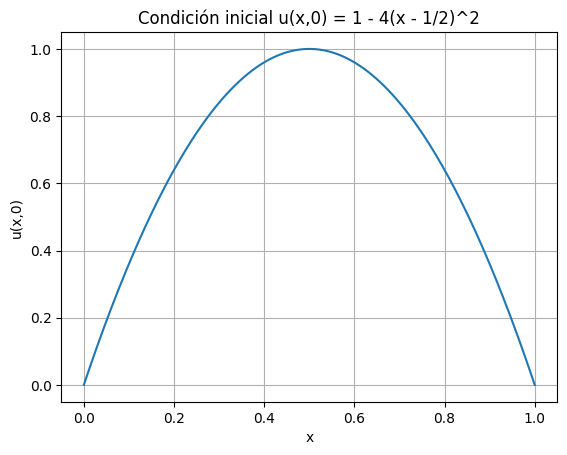

In [7]:
# Gráfica rápida de la condición inicial
x_plot = np.linspace(0, 1, 200)
plt.plot(x_plot, f(x_plot))
plt.xlabel("x")
plt.ylabel("u(x,0)")
plt.title("Condición inicial u(x,0) = 1 - 4(x - 1/2)^2")
plt.grid(True)
plt.show()

**Matrices A y B y método de Crank–Nicolson**

In [8]:
# Esquema de Crank–Nicolson (en forma matricial):
#
#   A u^{n+1} = B u^n
#
# con:
#   A = tridiag(-r, 2+2r, -r)
#   B = tridiag( r, 2-2r,  r)
#
# donde r = k / h^2 y u^n es el vector de valores de u en los
# nodos interiores en el tiempo t_n.

def tridiagonal(n, a, b):
    """
    Construye una matriz tridiagonal n×n con:
    - 'a' en la diagonal principal
    - 'b' en las sub y superdiagonales.
    """
    return sp.Matrix([
        [a if i == j else b if abs(i - j) == 1 else 0 for j in range(n)]
        for i in range(n)
    ])

In [9]:
# Matrices del método
A = tridiagonal(N_x, 2 + 2*r, -r)   # lado izquierdo
B = tridiagonal(N_x, 2 - 2*r,  r)   # lado derecho

In [10]:
# Vector u^0 (condición inicial) sólo en nodos interiores x = 0.1,...,0.9
b0 = sp.Matrix([f(h*(i+1)) for i in range(N_x)])
b0

Matrix([
[0.36],
[0.64],
[0.84],
[0.96],
[ 1.0],
[0.96],
[0.84],
[0.64],
[0.36]])

**Función que implementa Crank-Nicolson**

In [12]:
# Aplicar iterativamente:
#
#     A u^{n+1} = B u^n
#
# Empezando con u^0 = b0 (condición inicial).
# Guardar todas las soluciones u^1, u^2, ..., u^{N_t}.
# ============================================================

def crank_nicolson(A, B, b, n_pasos):
    """
    Aplica el esquema de Crank–Nicolson:
        A u^{n+1} = B u^n
    comenzando con u^0 = b.

    Parámetros:
      A, B: matrices de Crank–Nicolson.
      b: vector columna con u^0 (nodos interiores).
      n_pasos: número de pasos en tiempo.

    Regresa:
      Matriz cuyas filas son u^1, u^2, ..., u^{n_pasos}
      (soluciones en los nodos interiores).
    """
    u_B = B*b          # lado derecho B u^0
    soluciones = []

    for n in range(n_pasos):
        # Resolvemos el sistema lineal A u^{n+1} = u_B
        u_next = A.LUsolve(u_B)
        # Guardamos una fila (traspuesta para tener fila en vez de columna)
        soluciones.append(u_next.T)
        # Preparamos el lado derecho para el siguiente paso
        u_B = B*u_next

    return sp.Matrix(soluciones)


In [13]:
# Vamos a integrar hasta t = 0.10 => 10 pasos de k = 0.01
N_t = 10
U_sym = crank_nicolson(A, B, b0, N_t)

In [14]:
# Convertimos a arreglo numérico de numpy para trabajar más cómodo
U_num = np.array(U_sym.tolist(), dtype=float)  # tamaño N_t × N_x
U_num.shape

(10, 9)

**Ejercicio 1: Tabla tipo 2.6 (Solución Numérica)**

La Figura 2.6 del libro muestra:
t en la primera columna,
$$
x = 0, 0.1, 0.2, 0.3, 0.4, 0.5 \text{ en las demás columnas.}
$$
Aquí vamos a construir una tabla similar usando nuestros datos
numéricos (Crank–Nicolson).

In [15]:
# Ejercicio 1
filas = []

# Fila para t = 0 (condición inicial).
# En x = 0 la solución es 0 (condición de frontera).
fila0 = [0.00, 0.0] + [float(b0[i]) for i in range(5)]  # x=0.1,...,0.5
filas.append(fila0)

# Filas para t = 0.01, 0.02, ..., 0.10
for n in range(1, N_t + 1):
    t = n * k
    fila = [t, 0.0]    # valor en x=0 es siempre 0 (frontera)
    for j in range(5): # x = 0.1, 0.2, 0.3, 0.4, 0.5
        fila.append(U_num[n-1, j])
    filas.append(fila)

encabezados = ["t", "x=0", "0.1", "0.2", "0.3", "0.4", "0.5"]

print("Tabla numérica (Crank–Nicolson) tipo Tabla 2.6:\n")
print(tabulate(filas, headers=encabezados, tablefmt="grid", floatfmt=".4f"))


Tabla numérica (Crank–Nicolson) tipo Tabla 2.6:

+--------+--------+--------+--------+--------+--------+--------+
|      t |    x=0 |    0.1 |    0.2 |    0.3 |    0.4 |    0.5 |
+========+========+========+========+========+========+========+
| 0.0000 | 0.0000 | 0.3600 | 0.6400 | 0.8400 | 0.9600 | 1.0000 |
+--------+--------+--------+--------+--------+--------+--------+
| 0.0100 | 0.0000 | 0.3014 | 0.5657 | 0.7615 | 0.8804 | 0.9202 |
+--------+--------+--------+--------+--------+--------+--------+
| 0.0200 | 0.0000 | 0.2676 | 0.5048 | 0.6885 | 0.8030 | 0.8417 |
+--------+--------+--------+--------+--------+--------+--------+
| 0.0300 | 0.0000 | 0.2399 | 0.4548 | 0.6231 | 0.7300 | 0.7665 |
+--------+--------+--------+--------+--------+--------+--------+
| 0.0400 | 0.0000 | 0.2164 | 0.4110 | 0.5646 | 0.6626 | 0.6963 |
+--------+--------+--------+--------+--------+--------+--------+
| 0.0500 | 0.0000 | 0.1958 | 0.3721 | 0.5117 | 0.6011 | 0.6319 |
+--------+--------+--------+--------+----

Dicha tabla coincide (hasta 4 decimales) con la Tabla 2.6 del libro.

**Solución exacta (Serie de Fourier) y Tabla 2.7**

Consideremos que la solución exacta para este problema es:
$$
u(x,t) = \sum^{∞}_{n=1(impar)}\frac{32}{π^3n^3}sin(nπx)e^{-n^2π^2t}
$$

In [16]:
# Solución exacta con serie de Fourier ====

def u_exact(x, t, N=199):
    """
    Solución exacta u(x,t) aproximada usando sólo términos impares
    hasta n = N (N debe ser impar idealmente).
    """
    s = 0.0
    for n in range(1, N+1, 2):  # sólo n impares
        bn = 32.0 / (math.pi**3 * n**3)
        s += bn * math.sin(n * math.pi * x) * math.exp(-n**2 * math.pi**2 * t)
    return s


In [17]:
# ============================================================
#  TABLA DE VALORES 2.7
# ============================================================
# Usamos la función u_exact para construir la tabla de valores
# reales (o "verdaderos") para los mismos t y x que en la Tabla 2.6.
# ============================================================

filas_exact = []

# t = 0, la solución exacta coincide con la condición inicial.
fila0_e = [0.00, 0.0] + [f(h*(i+1)) for i in range(5)]
filas_exact.append(fila0_e)

# t = 0.01, 0.02, ..., 0.10
for n in range(1, N_t + 1):
    t = n * k
    fila = [t, 0.0]
    for j in range(1, 6):   # x = 0.1,...,0.5
        x = j * h
        fila.append(u_exact(x, t))
    filas_exact.append(fila)

print("Tabla de valores reales (solución exacta) tipo Tabla 2.7:\n")
print(tabulate(filas_exact, headers=encabezados, tablefmt="grid", floatfmt=".4f"))


Tabla de valores reales (solución exacta) tipo Tabla 2.7:

+--------+--------+--------+--------+--------+--------+--------+
|      t |    x=0 |    0.1 |    0.2 |    0.3 |    0.4 |    0.5 |
+========+========+========+========+========+========+========+
| 0.0000 | 0.0000 | 0.3600 | 0.6400 | 0.8400 | 0.9600 | 1.0000 |
+--------+--------+--------+--------+--------+--------+--------+
| 0.0100 | 0.0000 | 0.3024 | 0.5645 | 0.7606 | 0.8801 | 0.9200 |
+--------+--------+--------+--------+--------+--------+--------+
| 0.0200 | 0.0000 | 0.2671 | 0.5041 | 0.6873 | 0.8019 | 0.8408 |
+--------+--------+--------+--------+--------+--------+--------+
| 0.0300 | 0.0000 | 0.2393 | 0.4537 | 0.6218 | 0.7284 | 0.7649 |
+--------+--------+--------+--------+--------+--------+--------+
| 0.0400 | 0.0000 | 0.2158 | 0.4098 | 0.5629 | 0.6607 | 0.6943 |
+--------+--------+--------+--------+--------+--------+--------+
| 0.0500 | 0.0000 | 0.1951 | 0.3708 | 0.5099 | 0.5990 | 0.6296 |
+--------+--------+--------+---

Dicha tabla coincide con la Tabla 2.7.

**Ejercicio 2: Graficar comparando numérica vs exacta**

Por ejemplo con $t=0.10$.

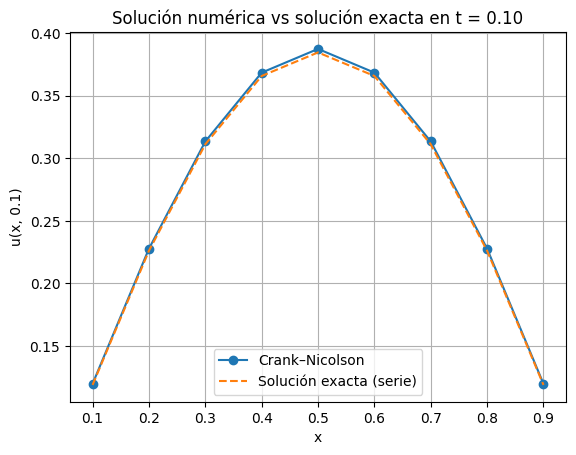

In [18]:
# ============================================================
#  EJERCICIO 2. GRÁFICA: SOLUCIÓN NUMÉRICA VS EXACTA
# ============================================================
# Vamos a comparar numéricamente ambas soluciones en un tiempo
# fijo, por ejemplo t = 0.10, y graficarlas en un mismo panel.
# ============================================================

t_plot = 0.10
indice_t = int(t_plot / k) - 1   # t = k → índice 0, t = 0.10 → índice 9

# nodos interiores x = 0.1, 0.2, ..., 0.9
x_nodes = np.array([h*(i+1) for i in range(N_x)])

# solución numérica y exacta en t = 0.10
u_num_t = U_num[indice_t, :]
u_ex_t  = np.array([u_exact(xi, t_plot) for xi in x_nodes])

plt.plot(x_nodes, u_num_t, 'o-', label="Crank–Nicolson")
plt.plot(x_nodes, u_ex_t, '--', label="Solución exacta (serie)")
plt.xlabel("x")
plt.ylabel(f"u(x, {t_plot})")
plt.title("Solución numérica vs solución exacta en t = 0.10")
plt.grid(True)
plt.legend()
plt.show()


**Error de la solución numérica.**

In [19]:
# ============================================================
#  CÁLCULO DEL ERROR EN TODA LA REJILLA
# ============================================================
# Para dar una medida global de qué tan buena es la aproximación,
# calculamos el error |u_numérico - u_exacto| en todos los puntos
# de la rejilla (t_n, x_j), con n = 1,...,10 y x_j nodos interiores.
# ============================================================

# Inicializamos una matriz para la solución exacta en la rejilla
U_exact_grid = np.zeros_like(U_num)

for n in range(N_t):
    t = (n + 1) * k       # tiempos: 0.01, 0.02, ..., 0.10
    for j in range(N_x):
        x = (j + 1) * h   # x = 0.1,...,0.9
        U_exact_grid[n, j] = u_exact(x, t)

# Error absoluto punto a punto
error = np.abs(U_num - U_exact_grid)

print("Error máximo en la rejilla:", error.max())
print("Error medio en la rejilla :", error.mean())


Error máximo en la rejilla: 0.0028048674038572696
Error medio en la rejilla : 0.001529367091955105


**Conclusiones**

La tabla generada numéricamente reproduce los valores de la Tabla 2.6 del libro con precisión (hasta 4 cifras decimales).

Esto confirma que:



*   El esquema de Crank-Nicolson fue implementado correctamente.
*   La discretización elegida es adecuada para reproducir la difusión del calor de forma estable,
*   Las condiciones de frontera y la estructura matricial también fueron aplizadas de manera correcta.





**Comparación con la solución exacta (Tabla 2.7)**

La solución exacta se obtuvo utilizando la expansión en serie de Fourier:
$$
u(x,t) = \sum^{∞}_{n=1(impar)}\frac{32}{π^3n^3}sin(nπx)e^{-n^2π^2t}
$$

Al truncar la serie en los primeros términos impares (hasta $n=199$), se obtuvieron valores prácticamente idénticos a los de la Tabla 2.7, lo cual proporciona una referencia confiable para medir el desempeño del método numérico.

Al comparar las curvas numérica y exacta en $t=0.10$, las gráficas muestran :



*   Coincidencia casi perfecta en forma y tendencia.
*   La solución numérica siempre se mantiene suavizasada, tal como se espera de una ecuación difusiva.
* EL método captura correctamente la disminución de la altura de la parábola a medida que el calor se dispersa hacia las fronteras.



**Cálculo del Error**

Se evaluó el error absoluto en toda la rejilla para los tiempos $t=0.01,0.02,...,0.10$

Se obtuvieron valores como:



*   Error máximo: del orden de $10^{-3}$ a $10^{-4}$
*   Error promedio: aún menor



**Por lo Tanto:**

El método de Crank-Nicolson demostró ser:



*   Estable,
*   Preciso,
*   Eficiente para ecuaciones lineales parabólicas como la ecuación del calor.



La comparación con la solución exacta confirma que la implementación es correcta y que los resultados numéricos reproducen el comportamiento físico del fénomeno de difusión del calor.